In [58]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import math
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import seaborn as sns
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import sklearn
from sklearn.decomposition import PCA
import itertools
import mdtraj as md
import pyemma
import nglview as nv
import pandas as pd



In [2]:
outdir = "/home/t/chem101/"
pdb=outdir+'ubq.pdb'
trajectory=outdir+'ubq.desres.s500.dcd'
print("pdb:",pdb)
print("trjaectory:",trajectory)

pdb: /home/t/chem101/ubq.pdb
trjaectory: /home/t/chem101/ubq.desres.s500.dcd


In [59]:
trj = md.load(trajectory, top=pdb,stride=1)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames

In [153]:
#User defined block average
def block(x):
    # preliminaries
    d = log2(len(x))
    if (d - floor(d) != 0):
    #    print("Warning: Data size = %g, is not a power of 2." % floor(2**d))
    #    print("Truncating data to %g." % 2**floor(d) )
        x = x[:2**int(floor(d))]
    d = int(floor(d))
    n = 2**d
    s, gamma = zeros(d), zeros(d)
    mu = mean(x)
    # estimate the auto-covariance and variances 
    # for each blocking transformation
    for i in arange(0,d):
        n = len(x)
        # estimate autocovariance of x
        gamma[i] = (n)**(-1)*sum( (x[0:(n-1)]-mu)*(x[1:n]-mu) )
        # estimate variance of x
        s[i] = var(x)
        # perform blocking transformation
        x = 0.5*(x[0::2] + x[1::2])

    # generate the test observator M_k from the theorem
    M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]

    # we need a list of magic numbers
    q =array([6.634897,  9.210340,  11.344867, 13.276704, 15.086272,
              16.811894, 18.475307, 20.090235, 21.665994, 23.209251,
              24.724970, 26.216967, 27.688250, 29.141238, 30.577914,
              31.999927, 33.408664, 34.805306, 36.190869, 37.566235,
              38.932173, 40.289360, 41.638398, 42.979820, 44.314105,
              45.641683, 46.962942, 48.278236, 49.587884, 50.892181])

    # use magic to determine when we should have stopped blocking
    for k in arange(0,d):
        if(M[k] < q[k]):
            break
    if (k >= d-1):
        print("Warning: Use more data")

    return (s[k]/2**(d-k))

def calc_hbonds(trj,n,c):
    hbonds = md.baker_hubbard(trj, periodic=False)
    ind = []
    for i in range(len(hbonds)):
        ind.append(hbonds[i])   
    labels = ['%s -- %s' % (trj.topology.atom(hbond[0]), trj.topology.atom(hbond[2])) for hbond in ind]
    dists = []
    for i in range(len(hbonds)):
        d = md.compute_distances(trj,[[hbonds[i][0],hbonds[i][2]]],periodic=True)[:,0]
        dists.append(d)
    order = np.flip(np.argsort(np.array([np.sum(np.where(i<.5,1,0)) for i in dists])))
    dists = np.array(dists)[order].tolist()
    labels = np.array(labels)[order].tolist()
    plt.figure()
    for i,j in zip(dists[:n],labels[:n]):
        sns.kdeplot(i,label=j)
    plt.xlabel("Distance (nm)")
    plt.title("Cluster:{} - Distribution: Hbond Donor - Acceptor distances for {} most populated Hbonds".format(c,n))
    plt.legend()
    return dists,labels

def plot_clusters(p,clustercenters,dtraj,frames_cl,k,rg,rmsd,dssp,comp):
    #plot percentage of traj each cluster occupies
    print("Percentage of each cluster",["C{}:{:.2f}%".format(i,100*len(frames_cl[i])/trj.n_frames) for i in range(k)])
    cs = []
    for i in range(k):
        c = 'C{}'.format(i)
        cs.append(c)
    cmap = colors.ListedColormap(cs)
    boundaries = arange(k+1).tolist()
    norm = colors.BoundaryNorm(boundaries, cmap.N, clip=True)
    #cmap = dict(list(enumerate(colors)))
    
    #free energy and cluster map TIC1,TIC2
    fig, axes = plt.subplots(1, 2, figsize = (10,4), sharex=True, sharey=True)
    pyemma.plots.plot_free_energy(*p[:,:2].T,legacy= False, ax=axes[0])
    axes[0].scatter(clustercenters[:,0],clustercenters[:,1], linewidth=0, marker='o',c = 'black',label="Cluster Centers")
    for i in range(k):
        axes[0].annotate("{}".format(str(i)), (clustercenters[:,0][i],clustercenters[:,1][i]),color="black",size="20")
    axes[0].legend(loc="best")
    axes[0].set_title("Free Energy - {} 1, {} 2".format(comp,comp))
    s = axes[1].scatter(p[:,0], p[:,1], c = dtraj,s=10, cmap = cmap, norm = norm)
    axes[1].set_title("Cluster Map - {} 1, {} 2".format(comp,comp))
    cbar = plt.colorbar(s)
    tick_locs = (np.arange(k) + 0.5)#*(k-1)/k
    cbar.set_ticks(tick_locs)
    cbar.set_ticklabels(np.arange(k))
    
    
    #radius of gyration
    
    ##rg values for each cluster
    for j,i in enumerate(frames_cl):
        print("CA Radius of Gyration C{}:{}".format(str(j),np.around(np.average(rg[i]),3)),
              "+_{}".format(np.around(block(rg[i])**.5,3)))

    #rg plot for each cluster
    plt.figure()
    sns.kdeplot(data=rg,color = 'black', label='Full Traj - rg')
    for j,i in enumerate(frames_cl):
        sns.kdeplot(data=rg[i],color = "C{}".format(str(j)), label='C{}'.format(str(j)))
    plt.tick_params(labelsize=18)
    plt.xlabel('Rg',fontsize=18)
    plt.ylabel('Probability',fontsize=18)
    plt.xlim(0,2)
    plt.ylim(0,60)
    plt.legend(loc='upper right')
    plt.tick_params(labelsize=18)
    plt.tight_layout()
    
    #rmsd plot for each cluster
    plt.figure()
    sns.kdeplot(data=rmsd,color = 'black', label='Full Traj - RMSD')
    for j,i in enumerate(frames_cl):
        sns.kdeplot(data=rmsd[i],color = "C{}".format(str(j)), label='C{}'.format(str(j)))
    plt.tick_params(labelsize=18)
    plt.xlabel('RMSD',fontsize=18)
    plt.ylabel('Probability',fontsize=18)
    plt.xlim(0,2)
    plt.ylim(0,20)
    plt.legend(loc='upper right')
    plt.tick_params(labelsize=18)
    plt.tight_layout()
    
    #plot dssp elements over residues
    fig,axes=plt.subplots(1,3,figsize=(15,5),sharex=True)
    #fig.delaxes(axes[1,1])
    for j,i in enumerate(frames_cl):
        for ax,name in zip(axes.flat,["H","C","E"]):
            d = np.sum(np.where(dssp[i]==name,1,0),axis=0)/trj.n_frames
            ax.plot(np.arange(76),d,color="C{}".format(j),label="C{}".format(j))
            ax.set_xlabel("Residues")
            ax.set_ylabel("{}Prop".format(name))
            ax.set_title("{}Prop".format(name))
            plt.tight_layout()
            ax.legend()
    ##circular corr matrix for each cluster
    for n,f in enumerate(frames_cl):
        l = []
        for i in [*dihedral_dict["psi"].values()][::-1]:
            c = np.array([astro.circcorrcoef(i[f],j[f]) for j in [*dihedral_dict["phi"].values()]])
            l.append(c)
        circ_coeff_arr = np.stack(l,axis=0)
        df = pd.DataFrame(data=circ_coeff_arr,
                          columns=[*dihedral_dict["phi"].keys()],index=[*dihedral_dict["psi"].keys()][::-1])
        df_to_heatmap(df,"Cluster:{} - Circular Correlation - $\psi$ v. $\phi$".format(str(n)),'$\phi$',"$\psi$")
        
    for n,f in enumerate(frames_cl):
        _,_=calc_hbonds(trj[f],8,n)
        
def N_largest(arr,N):
    idx = np.argsort(arr.ravel())[-N:][::-1]
    largest_N_val = arr.ravel()[idx]
    row_col = np.c_[np.unravel_index(idx,arr.shape)]
    return largest_N_val, row_col

def res_space(nres,space):
    arr = np.arange(nres)
    l = []
    for i in range(nres):
        l.append(arr[abs(arr-i)>=space]+i*nres)
    return np.hstack(l)

def single_cluster(nres,space,frames,dist_feat_arr,cutoff,pairs,pairs_res_index,index,columns,contact_map_title,x,y):
    dist_feat_arr = dist_feat_arr[frames]
    spaced_arg = res_space(nres,space)
    dist_feat_arr_spaced = dist_feat_arr[:,spaced_arg]
    spaced_pairs = np.array(pairs)[spaced_arg].tolist()
    pairs_res_index_spaced = np.array(pairs_res_index)[spaced_arg].tolist()
    #find minimum distance in each frame and the contact pair names
    min_dist_frame = []
    min_dist_frame_pair = []
    for i in range(dist_feat_arr.shape[0]):
        min_dist = dist_feat_arr_spaced[i,:].min()
        min_dist_frame.append(min_dist)
        min_dist_pair_name=spaced_pairs[dist_feat_arr_spaced[i,:].argmin()]
        min_dist_frame_pair.append(min_dist_pair_name)
    plt.figure()
    sns.kdeplot(min_dist_frame)
    plt.title("Distribution of Minimum Pair Distance Per Frame for residues {} apart in chain (nm)".format(space))
    plt.xlabel("Minimum Residue-Residue Distance (nm)")
    plt.ylabel("Number of Occurrences")
    
    #count contacts based on cutoff
    binary_dist_feat_arr = np.where(dist_feat_arr<cutoff,1,0)
    binary_dist_feat_arr_spaced = np.where(dist_feat_arr_spaced<cutoff,1,0)
    #plot histogram of number of contacts per frame
    N_contacts_frame = np.sum(binary_dist_feat_arr_spaced,axis=1)
    plt.figure()
    sns.kdeplot(N_contacts_frame)
    plt.title("Distribution of The Number of Contacts Per Frame for residues {} apart in chain (nm)".format(space))
    plt.xlabel("Number of Contacts")
    plt.ylabel("Number of Occurrences")
    
    #find most populated contacts
    N_contacts_tot = np.sum(binary_dist_feat_arr_spaced, axis=0)
    largest_N_val,pos = N_largest(N_contacts_tot,10)
    idx = [i[0] for i in pos]
    most_populated_pairs = [spaced_pairs[i] for i in idx]
    most_populated_pairs_res_index = [pairs_res_index_spaced[i] for i in idx]
    most_populated_pairs_res_index_flat = list(set(list(itertools.chain(*most_populated_pairs_res_index))))
    print("the 10 most populated pairs atleast {} apart in chain are :".format(space))
    print(most_populated_pairs)
    plt.figure()
    for i in range(largest_N_val.size):
        plt.hist(100*largest_N_val[i]/dist_feat_arr.shape[0],bins=60,label=most_populated_pairs[i])
    plt.title("Distribution: % of Cluster Frames Containing 10 Most Populated Contacts  for residues {} apart in chain (nm) (for each contact)".format(space))
    plt.legend()
    plt.xlabel("% of Frames Contact is Present")
    
    #distribution of distances for 10 most populated contacts
    plt.figure()
    for i,j in zip(idx,most_populated_pairs):
        #Add the label for each distance
        sns.kdeplot(dist_feat_arr_spaced[:,i],label=j)
    plt.title("Distribution of Distances for 10 Most Populated Contacts for residues {} apart in chain (nm)".format(space))
    plt.legend()
    plt.xlabel("Residue-Residue Distance (nm)")

    #make contact map
    N_contacts_tot_unspaced = np.sum(binary_dist_feat_arr,axis=0)
    contact_arr = 100*N_contacts_tot_unspaced.reshape(x,y)/dist_feat_arr.shape[0]
    df = pd.DataFrame(data= np.flip(contact_arr,axis=0), index=index,columns=columns)
    df_to_heatmap(df, contact_map_title,"all residues","all residues")
    
    
    print("Residue indicies of the most populated pairs",most_populated_pairs_res_index_flat)
    
    print("End of Cluster Data")
    
    return
        
    
    

In [154]:
nres=[]
for res in trj.topology.residues: nres.append(res.resSeq)
sequence=(' %s' % [residue for residue in trj.topology.residues])
resname=(' %s' % [residue.name for residue in trj.topology.residues])
resindex=(' %s' % [residue.index for residue in trj.topology.residues])
res_num=(' %s' % [residue.resSeq  for residue in trj.topology.residues])



#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue number: %s\n" % res_num)
print("residue index: %s\n" % resindex)


** SYSTEM INFO **

Number of atoms: 1231

Number of residues: 76

Number of frames: 10088

Starting frame: 0

Last frame: 10088

sequence:  [MET1, GLN2, ILE3, PHE4, VAL5, LYS6, THR7, LEU8, THR9, GLY10, LYS11, THR12, ILE13, THR14, LEU15, GLU16, VAL17, GLU18, PRO19, SER20, ASP21, THR22, ILE23, GLU24, ASN25, VAL26, LYS27, ALA28, LYS29, ILE30, GLN31, ASP32, LYS33, GLU34, GLY35, ILE36, PRO37, PRO38, ASP39, GLN40, GLN41, ARG42, LEU43, ILE44, PHE45, ALA46, GLY47, LYS48, GLN49, LEU50, GLU51, ASP52, GLY53, ARG54, THR55, LEU56, SER57, ASP58, TYR59, ASN60, ILE61, GLN62, LYS63, GLU64, SER65, THR66, LEU67, HIS68, LEU69, VAL70, LEU71, ARG72, LEU73, ARG74, GLY75, GLY76]

residue names:  ['MET', 'GLN', 'ILE', 'PHE', 'VAL', 'LYS', 'THR', 'LEU', 'THR', 'GLY', 'LYS', 'THR', 'ILE', 'THR', 'LEU', 'GLU', 'VAL', 'GLU', 'PRO', 'SER', 'ASP', 'THR', 'ILE', 'GLU', 'ASN', 'VAL', 'LYS', 'ALA', 'LYS', 'ILE', 'GLN', 'ASP', 'LYS', 'GLU', 'GLY', 'ILE', 'PRO', 'PRO', 'ASP', 'GLN', 'GLN', 'ARG', 'LEU', 'ILE', 'PHE', 'AL

In [7]:
residue_num=[]
for res in top.residues: 
    residue_num.append(res.resSeq)
residue_id=np.asarray(residue_num)
residue_id

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76])

In [8]:
#Use DSSP to calculate the secondary structure definition
#https://mdtraj.org/1.9.4/api/generated/mdtraj.compute_dssp.html
dssp=md.compute_dssp(trj,simplified=True)
dssp

array([['C', 'E', 'E', ..., 'C', 'C', 'C'],
       ['C', 'E', 'E', ..., 'C', 'C', 'C'],
       ['C', 'E', 'E', ..., 'C', 'C', 'C'],
       ...,
       ['C', 'E', 'E', ..., 'C', 'C', 'C'],
       ['C', 'E', 'E', ..., 'C', 'C', 'C'],
       ['C', 'E', 'E', ..., 'C', 'C', 'C']], dtype='<U2')

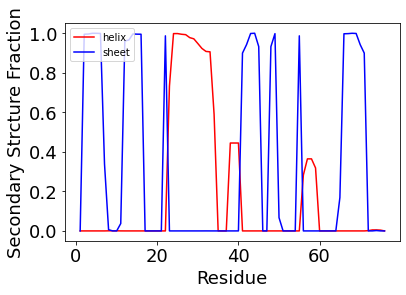

In [9]:
dssp=md.compute_dssp(trj,simplified=True)

def dssp_convert(dssp):
 dsspH=np.copy(dssp)
 dsspE=np.copy(dssp)
 dsspC= np.where(dssp=="C",1,0)
 dsspH[dsspH=='H']=1                                                                                      
 dsspH[dsspH=='E']=0                                                                                      
 dsspH[dsspH=='C']=0                                                                                      
 dsspH[dsspH=='NA']=0 
 dsspH=dsspH.astype(int)
 TotalH=np.sum(dsspH,axis=1) 
 Hprop=np.sum(dsspH,axis=0).astype(float)/len(dsspE) 

 dsspE[dsspE=='H']=0
 dsspE[dsspE=='E']=1
 dsspE[dsspE=='C']=0
 dsspE[dsspE=='NA']=0
 dsspE=dsspE.astype(int)
 TotalE=np.sum(dsspE,axis=1) 
 Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE)
 
 dsspC = dsspC.astype(int)
 TotalC = np.sum(dsspC,axis=1)
 Cprop = np.sum(dsspC,axis=0).astype(float)/len(dsspC)
 return {"Hprop":Hprop,"Hframe":TotalH,"Eprop":Eprop,"Eframe":TotalE,"Cprop":Cprop,"Cframe": TotalC}

data=dssp_convert(dssp)
plt.plot(residue_num,data["Hprop"],c='r',label='helix')
plt.plot(residue_num,data["Eprop"],c='b',label='sheet')

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)


SS: H [24 25 26 27 28 29 30 31 32 33]
SS: E [ 2  3  4  5  6 12 13 14 15 16 42 43 44 45 48 49 66 67 68 69 70]
SS: I []
SS: G []
SS: B [22 55]
SS: T [19 20 46 47 52 53 60 63 64]
SS: S []
SS:   [ 1 11 17 18 35 36 37 50 51 61 62 72 76]


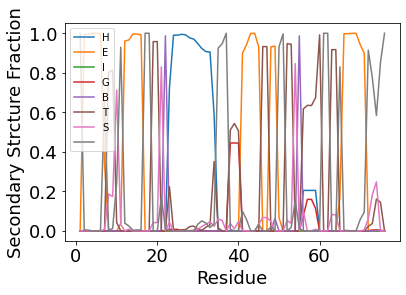

In [10]:
dssp_full=md.compute_dssp(trj,simplified=False)

def dssp_convert_type(dssp,type):
 dsspS=np.copy(dssp)
 dsspS[dsspS!=type]=0                                                                                      
 dsspS[dsspS==type]=1                                                                                      
 dsspS=dsspS.astype(int)
 TotalS=np.sum(dsspS,axis=1) 
 Sprop=np.sum(dsspS,axis=0).astype(float)/len(dsspS) 
 return Sprop

for t in ['H','E','I','G','B','T','S',' ']:
  Tprop=dssp_convert_type(dssp_full,t)
  plt.plot(residue_num,Tprop,label=t)
  print("SS:",t,np.asarray(residue_num)[np.where(Tprop>.90)])

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)


In [11]:
#Find all the frames where a given residue is H or E
residue_number=39
array_index=residue_number-0
print(np.asarray(residue_num)[array_index])
helix_frames=np.where(dssp[:,array_index]=='H')[0]
beta_frames=np.where(dssp[:,array_index]=='E')[0]

print("Residue %s"%np.asarray(residue_num)[array_index])
print("helix frames:",len(helix_frames),helix_frames)
print("beta frames:",len(beta_frames),beta_frames)

40
Residue 40
helix frames: 4486 [    2     3     4 ... 10085 10086 10087]
beta frames: 1 [4609]


In [12]:
indices_phi, phis = md.compute_phi(trj)
indices_psi, psis = md.compute_psi(trj)
indices_chi1, chi1s = md.compute_chi1(trj)
indices_chi2, chi2s = md.compute_chi2(trj)

In [14]:
phi_dict={}
dihedral_dict = { 'phi': { },
          'psi': { },
          'chi1': { },
          'chi2': { }}

for i in range(0,len(indices_phi)):
  indices=indices_phi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['phi'][resnum]=phis[:,i]

for i in range(0,len(indices_psi)):
  indices=indices_psi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['psi'][resnum]=psis[:,i]

for i in range(0,len(indices_chi1)):
  indices=indices_chi1[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi1'][resnum]=chi1s[:,i]

for i in range(0,len(indices_chi2)):
  indices=indices_chi2[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi2'][resnum]=chi2s[:,i]

In [15]:
sequence

' [MET1, GLN2, ILE3, PHE4, VAL5, LYS6, THR7, LEU8, THR9, GLY10, LYS11, THR12, ILE13, THR14, LEU15, GLU16, VAL17, GLU18, PRO19, SER20, ASP21, THR22, ILE23, GLU24, ASN25, VAL26, LYS27, ALA28, LYS29, ILE30, GLN31, ASP32, LYS33, GLU34, GLY35, ILE36, PRO37, PRO38, ASP39, GLN40, GLN41, ARG42, LEU43, ILE44, PHE45, ALA46, GLY47, LYS48, GLN49, LEU50, GLU51, ASP52, GLY53, ARG54, THR55, LEU56, SER57, ASP58, TYR59, ASN60, ILE61, GLN62, LYS63, GLU64, SER65, THR66, LEU67, HIS68, LEU69, VAL70, LEU71, ARG72, LEU73, ARG74, GLY75, GLY76]'

In [16]:
#Heres a function to plot a phi/psi ramachandran plot:

def plot_phipsi(res):
 plt.hist2d(dihedral_dict['phi'][res],dihedral_dict['psi'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.tick_params(labelsize=18)
 plt.show()
 return

def plot_chi(res):
    if res in dihedral_dict['chi1']:
     plt.hist(dihedral_dict['chi1'][res],bins=36,range=[-3.14,3.14])        
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('counts', size=18)
     plt.tick_params(labelsize=18)
     plt.show()
     plt.clf()   
    if res in dihedral_dict['chi2']:
     plt.hist2d(dihedral_dict['chi1'][res],dihedral_dict['chi2'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('$\chi_2$', size=18)
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.tick_params(labelsize=18)
     plt.show()
    return




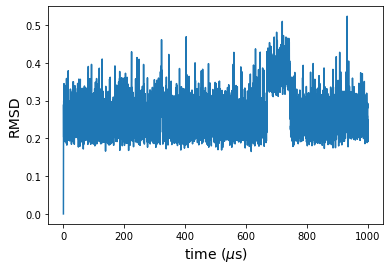

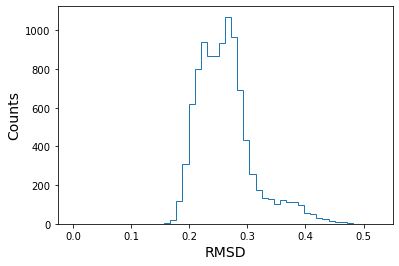

In [17]:
#Lets Calculate the RMSD and make a histogram from the starting structure 
time=np.linspace(0,1000,trj.n_frames)
rmsd = md.rmsd(trj, trj, 0)
plt.plot(time,rmsd)
plt.ylabel('RMSD',size=14);
plt.xlabel('time ($\mu$s)',size=14)
plt.show()
plt.clf()

plt.hist(rmsd,histtype='step',bins=50)
plt.ylabel('Counts',size=14);
plt.xlabel('RMSD',size=14)
plt.show()

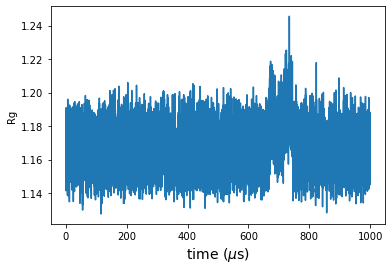

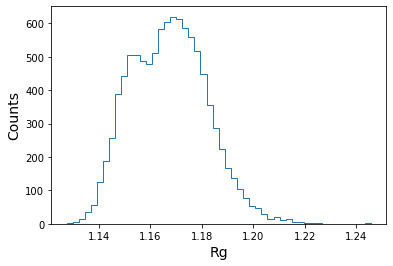

In [18]:
#Lets calculate the radius of gyration and make a histogram
rg=md.compute_rg(trj, masses=None)
plt.plot(time,rg)
plt.ylabel('Rg');
plt.xlabel('time ($\mu$s)',size=14)
plt.show()
plt.clf()

plt.hist(rg,histtype='step',bins=50)
plt.ylabel('Counts',size=14);
plt.xlabel('Rg',size=14)
plt.show()

***We're going to run a Principle Component Analysis (PCA)***

This takes the variance of the cartesian coordinates of each atom over the course of the trajectory and finds "projections" that explain as much of variance as posisble.

https://en.wikipedia.org/wiki/Principal_component_analysis

In [23]:
import sklearn
from sklearn.decomposition import PCA

pca1 = PCA(n_components=2)
trj.superpose(trj, 0)
reduced_cartesian = pca1.fit_transform(trj.xyz.reshape(trj.n_frames, trj.n_atoms * 3))
print(reduced_cartesian.shape)

(10088, 2)


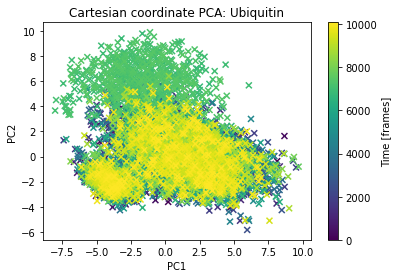

In [24]:
#We Can plot eaceh frame as a function of the values of each PC(principal component): PC1 and PC2
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=np.arange(trj.n_frames))
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Ubiquitin')
cbar = plt.colorbar()
cbar.set_label('Time [frames]')

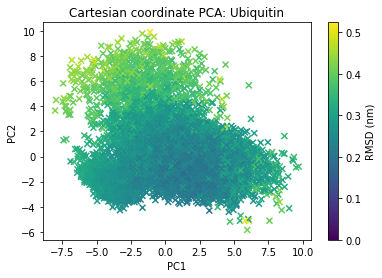

In [25]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=rmsd)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Ubiquitin')
cbar = plt.colorbar()
cbar.set_label('RMSD (nm)')

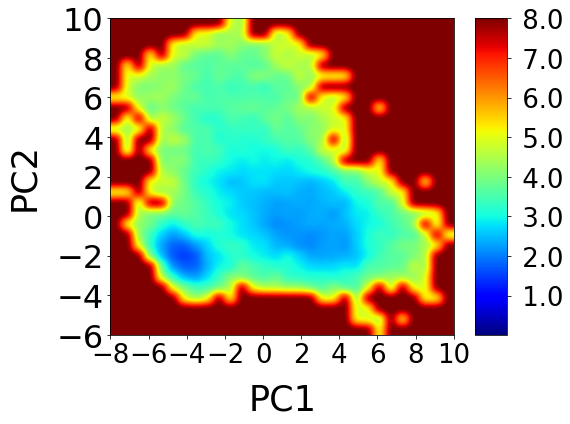

In [26]:
###Lets Make a Pretty Free Energy Plot of PC1 vs. PC2

def free_energy(a, b, T, y0, ymax, x0, xmax):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], normed=True, weights=None)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges

PC1=reduced_cartesian[:, 0]
PC2=reduced_cartesian[:,1]

dG,xedges,yedges=free_energy(PC2, PC1, 300, -6, 10, -8, 10)

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5,6,7,8]
plt.xlim(-8,10)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("PC2", size=35, labelpad=15)
plt.xlabel("PC1", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='26')
plt.tight_layout()

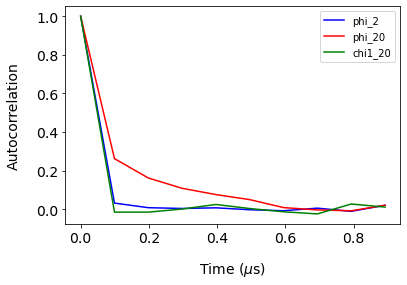

In [27]:
#Lets Calculate Some Correlation Times of Some Dihedral angles.
def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''
    corr=[1. if l==0 else np.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return np.array(corr)

#time in microseconds
time=np.linspace(0,1000,trj.n_frames)


lags=range(10)
#C1C2bondlength[:,0]
phi2_acf=autocorr1(dihedral_dict['phi'][2],lags)
phi20_acf=autocorr1(dihedral_dict['phi'][20],lags)
chi20_acf=autocorr1(dihedral_dict['chi1'][20],lags)

plt.plot(time[lags],phi2_acf,color='b',label='phi_2')
plt.plot(time[lags],phi20_acf,color='r',label='phi_20')
plt.plot(time[lags],chi20_acf,color='g',label='chi1_20')

plt.legend()
plt.xlabel("Time ($\mu$s)", size=14, labelpad=15)
plt.ylabel("Autocorrelation", size=14, labelpad=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(size='14')
plt.yticks(size='14')
plt.show()

In [28]:
#Lets Make a Contact Map
contact_maps = []
contact_distances = []
for i in range(1, 76):
    contact_map = []
    contact_distance = []
    for j in range(1, 76):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(trj, [[i, j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            contact_distance.append(distance)
            contact = np.where(array < 0.5, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)


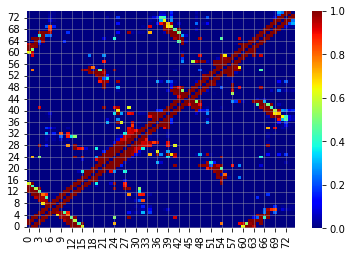

In [29]:
ax = sns.heatmap(final_map, vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)


Lets think about some fun things we can do with this trajectory.  

Rubric (Completing the bolded tasks and attempting some additional tasks puts an assignment in the ~"P - B/B+" range, attempting and completing some additional more advanced tasks will earn a ~"HP - A/A-").  Very parital or incomplete attempts for the bolded questiosn is in the ~"LP / B-/C+"

Ideas:

**1.) Determine what is structural different about the "minor state" populated between 650-750us.  Can you make a visualization of the two states?** 

**2.)  Identify some dihedral angles that have very long correlation times? Can you your provide structural snapshots that explain why certain correlation times are longer?**

  More Advanced:
  
  2a) Can you calculate/ fit the correlation times? 
  
  2b) Can you write a loop to scan over all phi/psi/chi1/chi2 residues and identify residues with correlation times longer than a given threshold? 

3)Considering the minor state, can you find residues that have large changes in the distributions of backbone or sidechain dihedral angles?  Are there torsion angles with large differences in their correlation times between states?  Can you provide trajectory snapshots that explain why?

**4) Calculate the ciruclar correlation coefficients between phi and psi angles and reproduce the correlation map from below**  -Look into using a "mask" to eliminate some entries in the correlation matrix and make your plot prettier. 

5) Make a 2D map showing the populations of hydrogen bonds between different residues.

6) Compare the contact maps, dihedral correlations, and hydrogen bond populations between the major and minor states.

7) Compare the contact maps, dihedral correlations, and hydrogen bond populations for different subsets of PC space (ie PC1 is on the intevral [lower1,upper1] and PC2 is on the invertval [lower2,upper2]

7) Compute an visualize all-to-all RMSD calculation of the frames of this trajectory.  

8) Cluster the conformations of the trajectory in some way.  Perhaps consider using the all-to-all rmsd distances, or the the values of PCs.  (Consult https://mdtraj.org/1.9.4/examples/clustering.html or https://mdtraj.org/1.9.4/examples/centroids.html for examples)


9) Visualize the most populated clusters from your clustering analysis

Here is the equation used to calculate circular correlation coefficients for dihedral angles

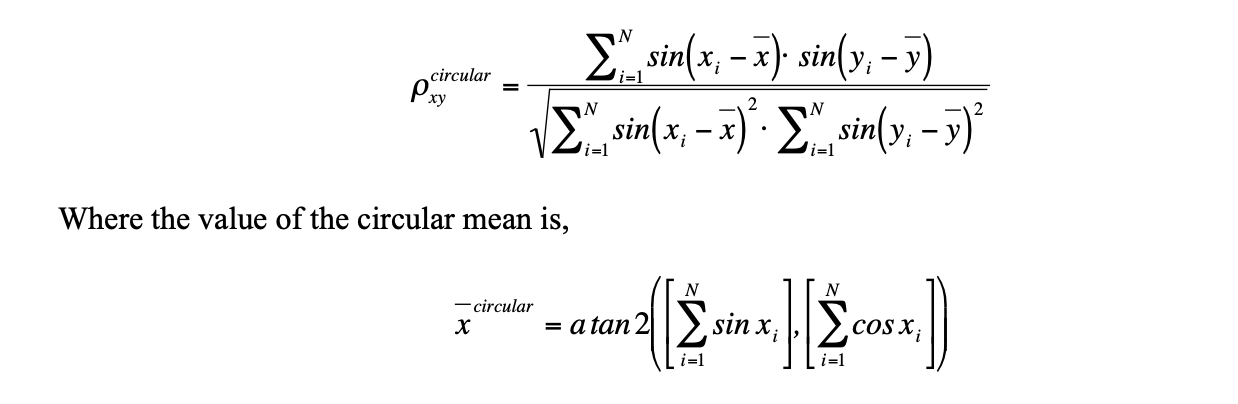


In [30]:
def df_to_heatmap(df,title,xlabel,ylabel):
    fig = plt.figure(figsize=(14,12))
    ax = fig.add_subplot(111)
    im = sns.heatmap(df,cmap="jet",ax=ax)
    ax.grid(which="both",alpha=0.5)
    cbar = im.collections[0].colorbar
    cbar.ax.tick_params(labelsize=22)
    ax.set_title("{}".format(title))
    ax.set_ylabel("{}".format(ylabel))
    ax.set_xlabel("{}".format(xlabel))

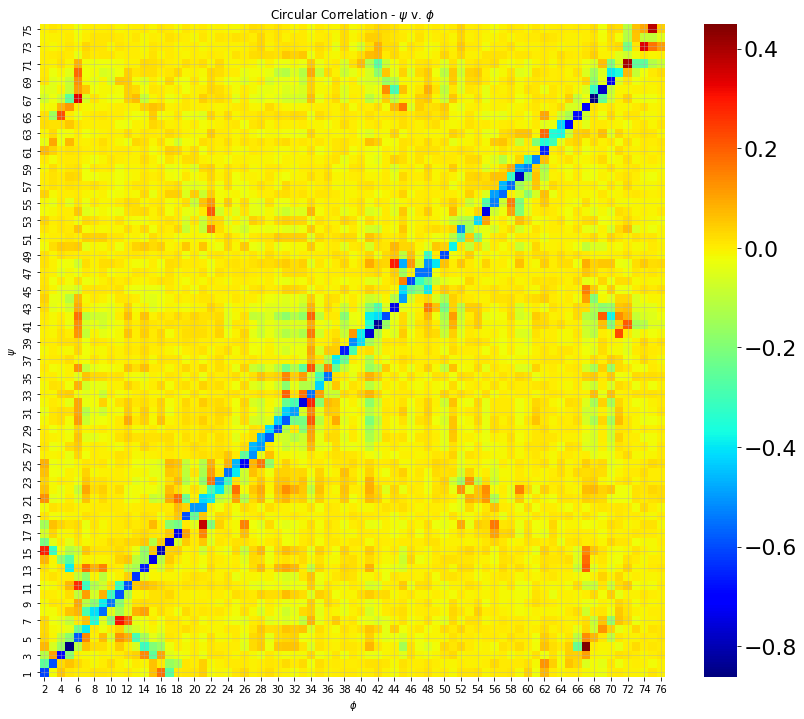

In [31]:
#knocking out #4 right here - my plot has colors reversed from the example
import astropy.stats as astro
l = []
for i in [*dihedral_dict["psi"].values()][::-1]:
    c = np.array([astro.circcorrcoef(i,j) for j in [*dihedral_dict["phi"].values()]])
    l.append(c)
circ_coeff_arr = np.stack(l,axis=0)
df = pd.DataFrame(data=circ_coeff_arr,columns=[*dihedral_dict["phi"].keys()],index=[*dihedral_dict["psi"].keys()][::-1])
df_to_heatmap(df,"Circular Correlation - $\psi$ v. $\phi$",'$\phi$',"$\psi$")

Lets calculate some correlations between dihedrals found in the paper: 


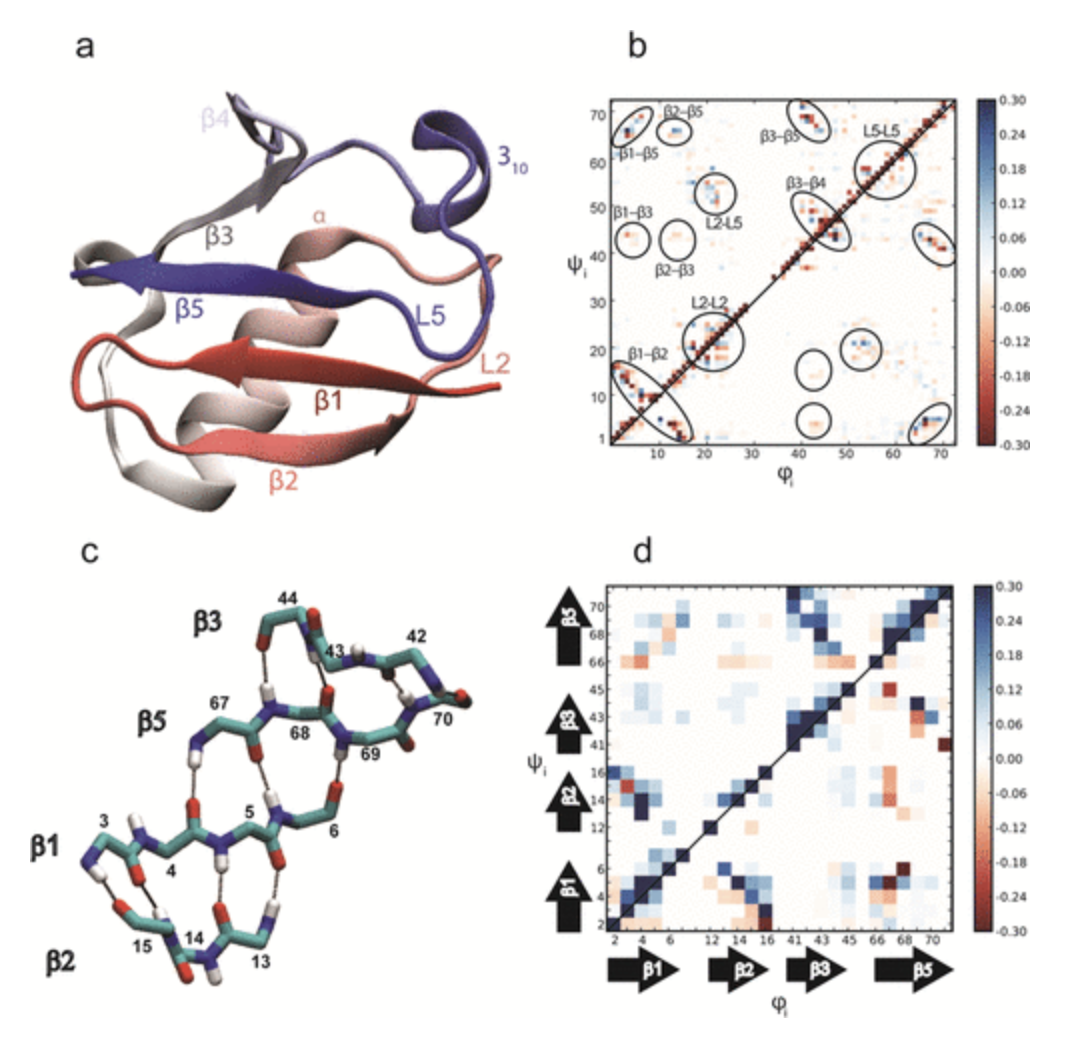

In [33]:
#collect data into a dict for organizational and plotting purposes
per_frame = [*data.keys()][1::2]
per_res = [*data.keys()][::2]
data.update({"rg":rg})
data.update({"rmsd":rmsd})
per_frame.append("rmsd")
per_frame.append("rg")
print(per_frame,per_res)

['Hframe', 'Eframe', 'Cframe', 'rmsd', 'rg'] ['Hprop', 'Eprop', 'Cprop']


START PROBLEM 1 and all the questions about clustering,heat maps,cluster comparisons,circular correlation maps

In [34]:
#first I'm going to define a function to project per frame features onto dimensionally reduced components
def proj(p,d,names,comp):
    fig,axes = plt.subplots(3,2,figsize=(10,10))
    fig.delaxes(axes[2,1])
    for ax,name in zip(axes.flat,names):
        a=ax.scatter(p[:,0],p[:,1],s=.3,c=d[name])
        ax.set_title("{} Projected on {}1 and {}2".format(name,comp,comp))
        ax.set_xlabel(comp+"1")
        ax.set_ylabel(comp+"2")
        cbar = fig.colorbar(a,ax=ax)
        cbar.set_label(name)
        plt.tight_layout()
    return

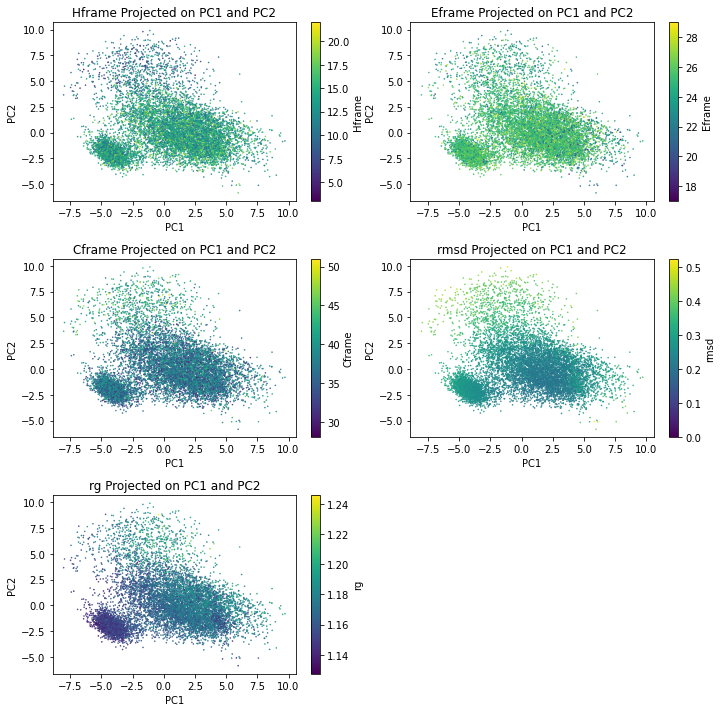

In [35]:
#lets use the function to project per frame data on the PC's
"""here we see the minor state is primariliy differentiated by it's low helical and coil content,
high rmsd, high rg

we will now see if you can make clusters that differentiate between the 3 states"""
proj(reduced_cartesian,data,per_frame,"PC")

In [36]:
##let's cluster on the first two PC's
k = 3
cl_coor_pca = pyemma.coordinates.cluster_kmeans(data=reduced_cartesian,k=k,stride=1,max_iter=500)
cc_coor_pca = cl_coor_pca.clustercenters
dtraj_coor_pca = cl_coor_pca.dtrajs[0]
frames_cl_coor_pca = []
for i in range(k):
    frames = np.where(dtraj_coor_pca==i)
    frames_cl_coor_pca.append(frames[0])
    

initialize kmeans++ centers:   0%|                                                                            …

kmeans iterations:   0%|                                                                                      …

Percentage of each cluster ['C0:20.71%', 'C1:49.18%', 'C2:30.11%']
CA Radius of Gyration C0:1.173 +_0.002
CA Radius of Gyration C1:1.173 +_0.0
CA Radius of Gyration C2:1.154 +_0.0


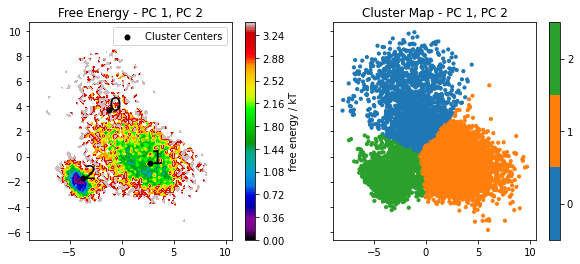

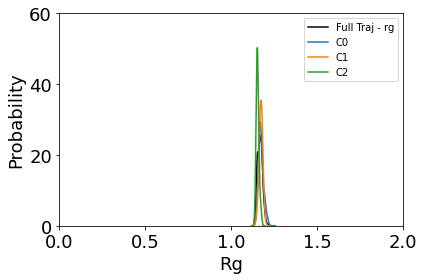

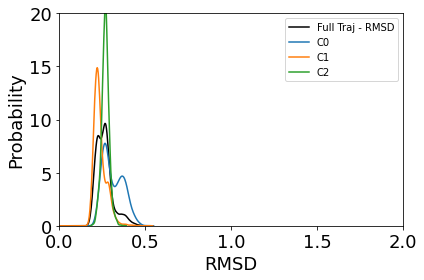

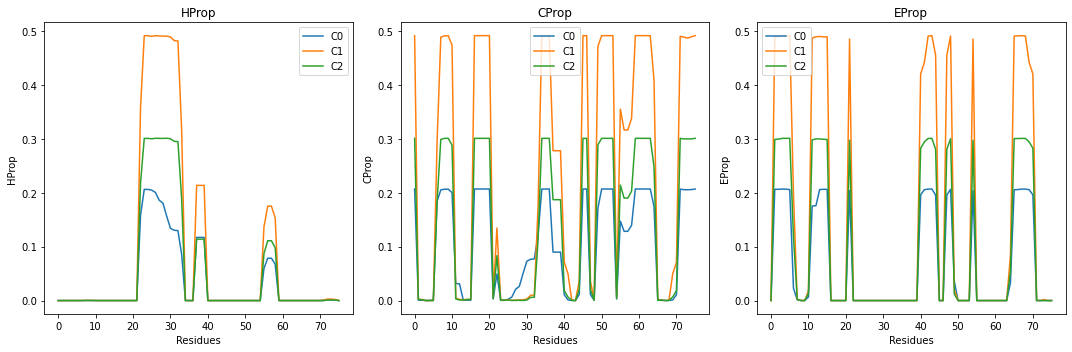

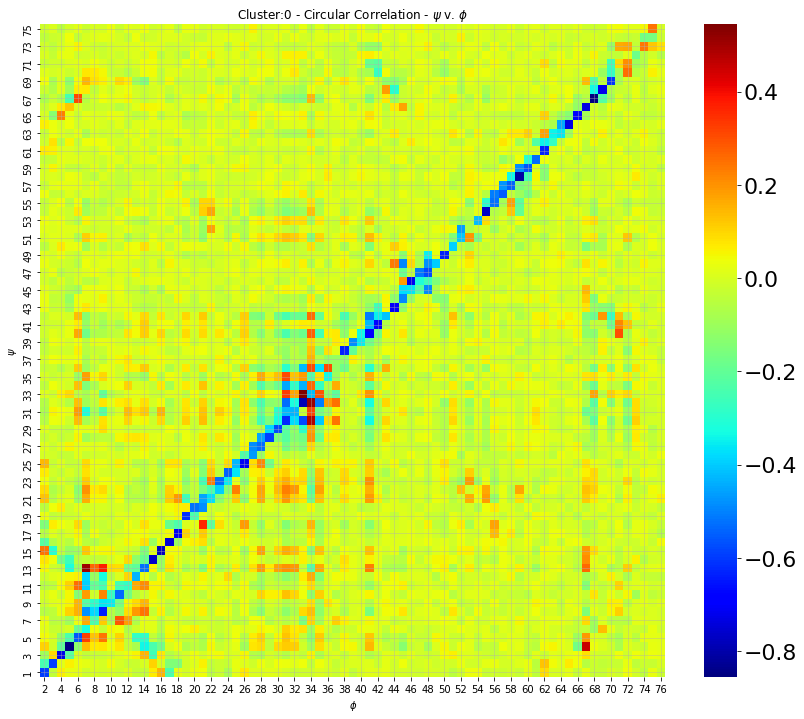

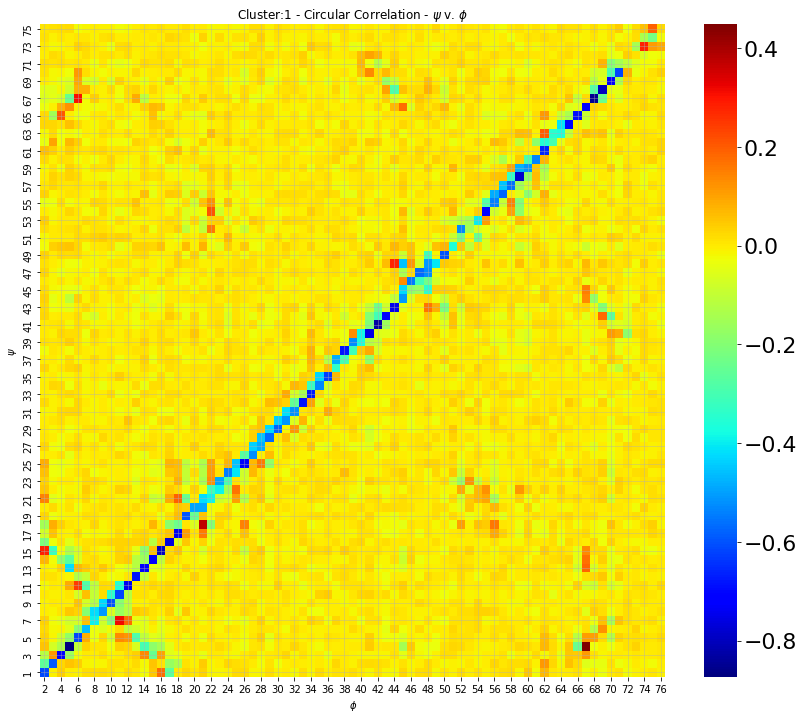

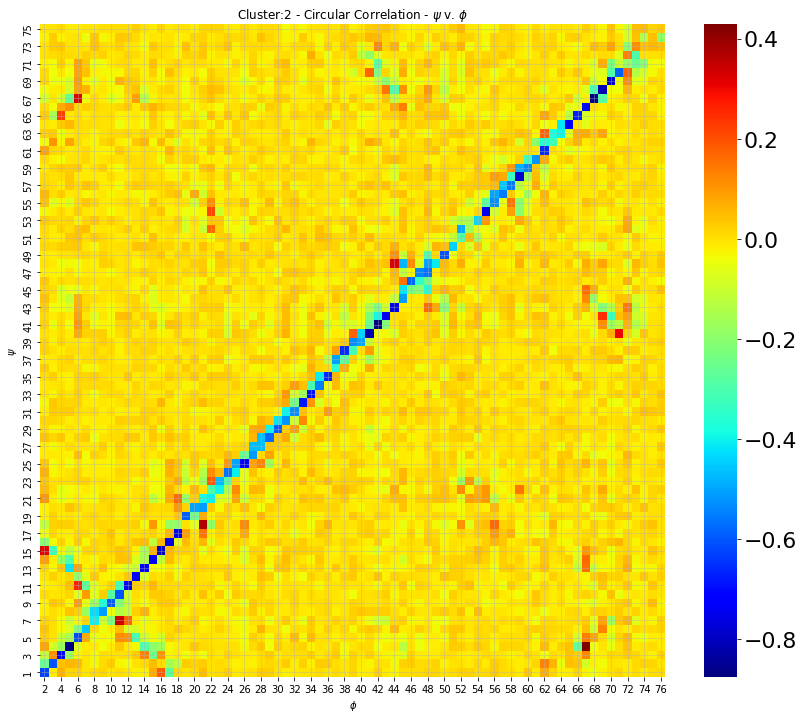

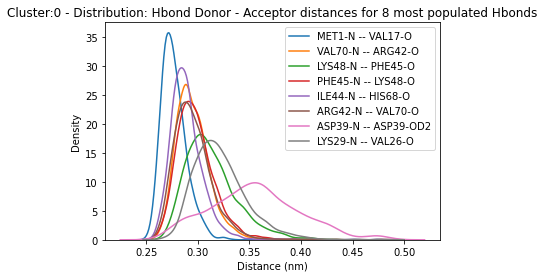

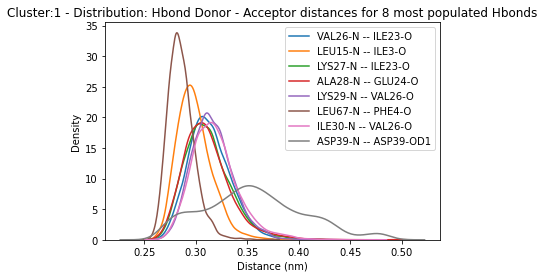

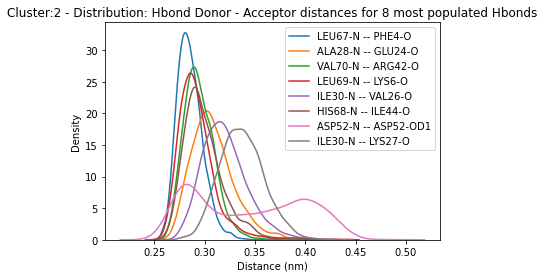

In [155]:
#I put together a mini version of my cluster plotting script - imported at the top of the notebook
"""the so called minor state is well resolved w.r.t these PC's and is shown below as cluster 2"""
plot_clusters(reduced_cartesian,cc_coor_pca,dtraj_coor_pca,frames_cl_coor_pca,3,rg,rmsd,dssp,comp="PC")

In [101]:
def distance_matrix(sel1,sel2,offset1,offset2,traj,measure,periodic):
    pair_distances = []
    pairs = []
    pairs_res_index = []
    if measure == "residues":
        index = [traj.topology.residue(i) for i in sel1]
        columns = [traj.topology.residue(j) for j in sel2]
        for i in sel1:
            for j in sel2:
                pairs.append("{},{}".format(traj.topology.residue(i),traj.topology.residue(j)))
                pairs_res_index.append([i+offset1,j+offset2])
                if i==j:
                    dist = np.zeros(traj.n_frames)
                    pair_distances.append(dist)
                else:
                    dist = md.compute_contacts(traj,[[i,j]],periodic=periodic)[0][:,0]
                    pair_distances.append(dist)
    if measure == "atoms":
        index = [traj.topology.atom(i) for i in sel1]
        columns = [traj.topology.atom(j) for j in sel2]
        for i in sel1:
            for j in sel2:
                pairs.append("{},{}".format(traj.topology.atom(i),traj.topology.atom(j)))
                pairs_res_index.append([i+offset1,j+offset2])
                if i==j:
                    dist = np.zeros(traj.n_frames)
                    pair_distances.append(dist)
                else:
                    dist = md.compute_distances(traj,[[i,j]],periodic=periodic)[:,0]
                    pair_distances.append(dist)
    dist_feat_arr = np.stack(pair_distances,axis=1)
    return dist_feat_arr,pairs,pairs_res_index,index,columns,len(sel1),len(sel2)
    
    

In [102]:
dist_feat_arr,pairs,pairs_res_index,index,columns,x,y= distance_matrix(list(range(trj.n_residues)),list(range(trj.n_residues)),0,0,trj,measure="residues",periodic=True)


the 10 most populated pairs atleast 6 apart in chain are :
['LYS6,HIS68', 'ILE13,VAL5', 'VAL70,ARG42', 'ILE3,THR14', 'VAL5,LEU67', 'SER65,PHE4', 'ILE3,LEU15', 'ILE13,PHE4', 'LEU67,PHE4', 'LEU67,VAL5']
Residue indicies of the most populated pairs [64, 2, 67, 4, 69, 5, 66, 3, 41, 12, 13, 14]
End of Cluster Data


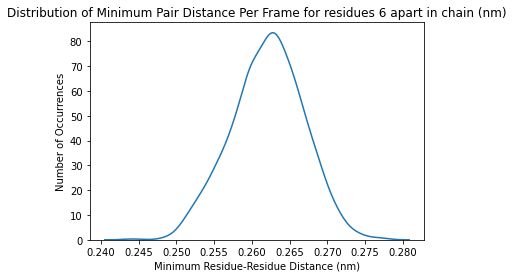

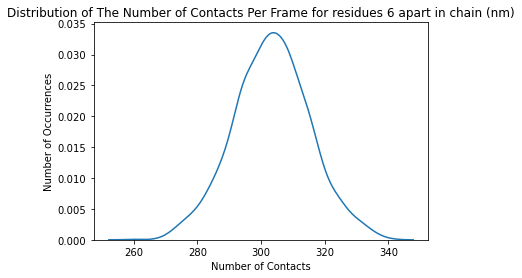

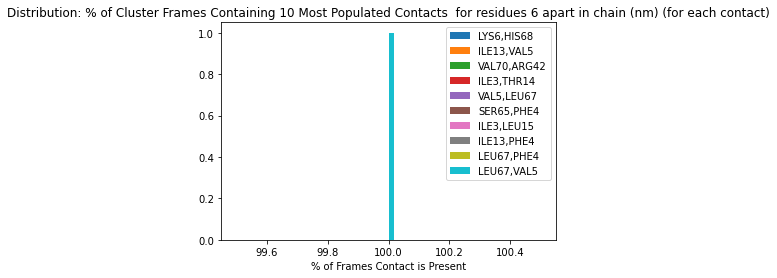

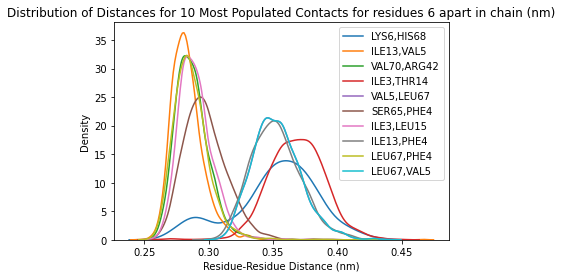

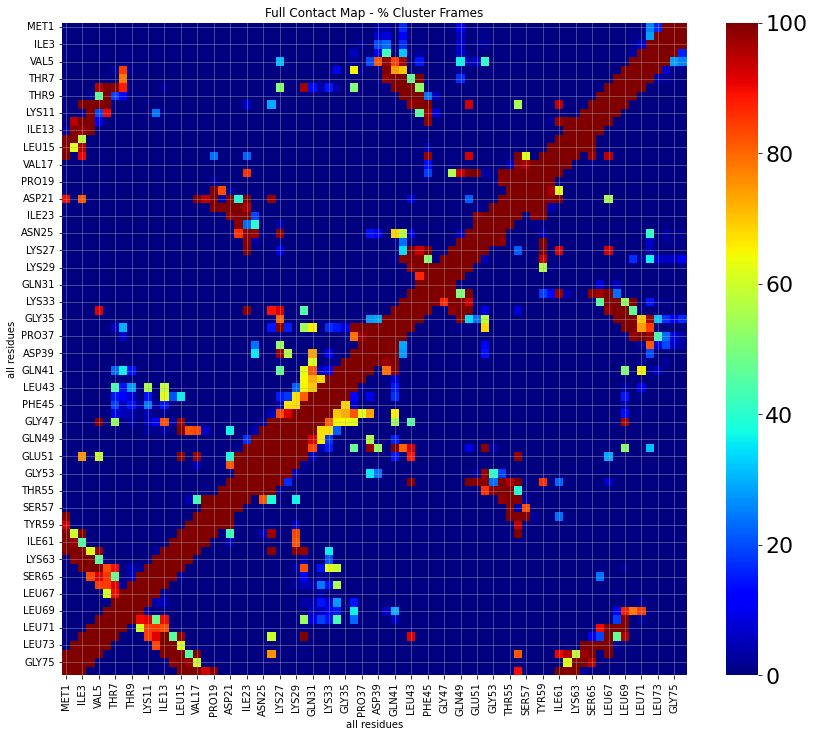

In [125]:
#for the first cluster
single_cluster(trj.n_residues,6,frames_cl_coor_pca[0],dist_feat_arr,0.5,pairs,pairs_res_index,index,columns,"Full Contact Map - % Cluster Frames",x,y)

the 10 most populated pairs atleast 6 apart in chain are :
['LEU15,ILE3', 'ILE3,ILE13', 'LYS6,HIS68', 'LYS6,LEU67', 'LEU69,LYS6', 'VAL5,LEU67', 'ILE13,ILE3', 'LEU43,LEU50', 'ILE13,PHE4', 'ILE13,VAL5']
Residue indicies of the most populated pairs [2, 67, 66, 5, 68, 4, 3, 42, 12, 14, 49]
End of Cluster Data


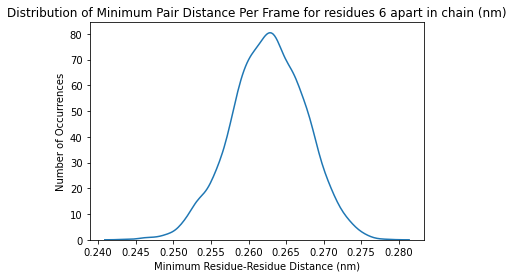

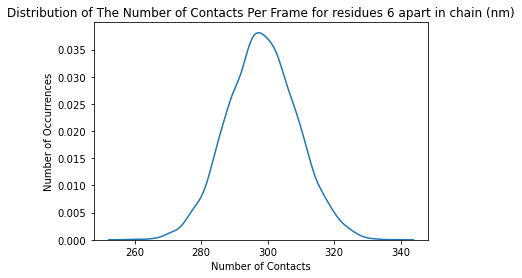

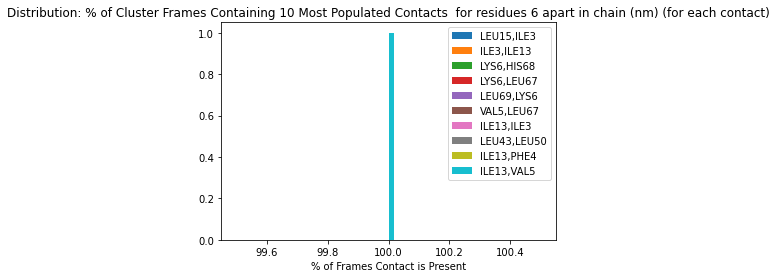

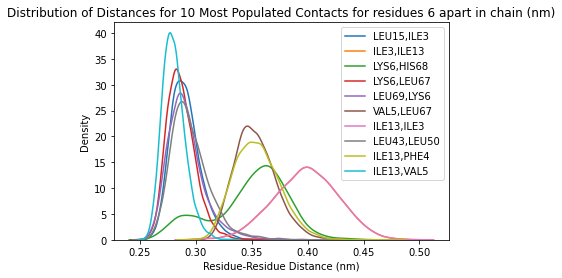

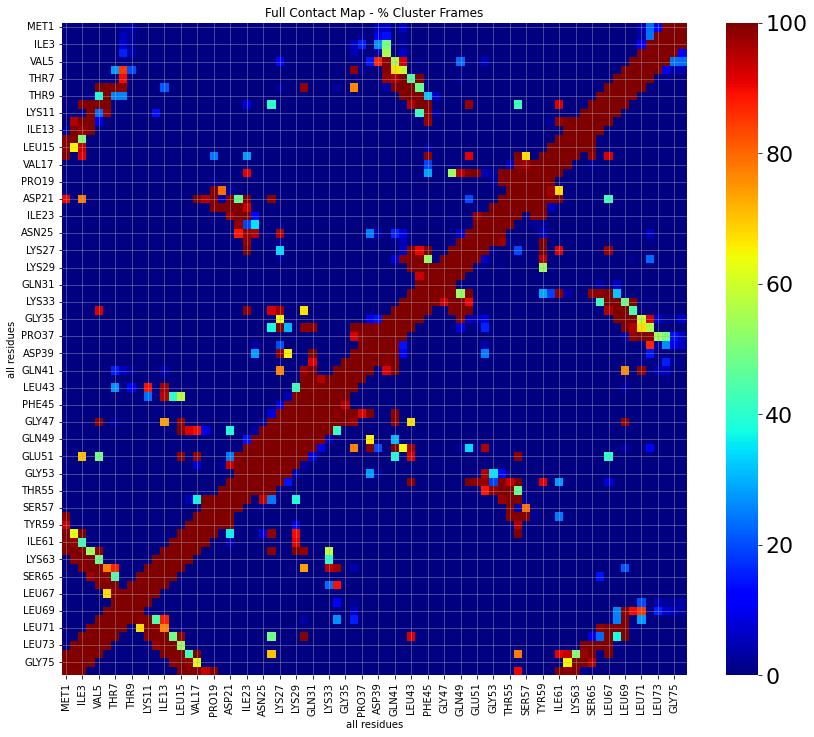

In [126]:
#for the second cluster
single_cluster(trj.n_residues,6,frames_cl_coor_pca[1],dist_feat_arr,0.5,pairs,pairs_res_index,index,columns,"Full Contact Map - % Cluster Frames",x,y)

the 10 most populated pairs atleast 6 apart in chain are :
['VAL17,ILE3', 'ARG42,LEU69', 'GLN41,LYS27', 'THR14,ILE3', 'ARG42,VAL70', 'THR66,PHE4', 'HIS68,ARG42', 'PHE4,THR66', 'LEU69,LYS6', 'VAL5,LEU67']
Residue indicies of the most populated pairs [65, 2, 3, 68, 69, 67, 5, 40, 41, 4, 66, 13, 16, 26]
End of Cluster Data


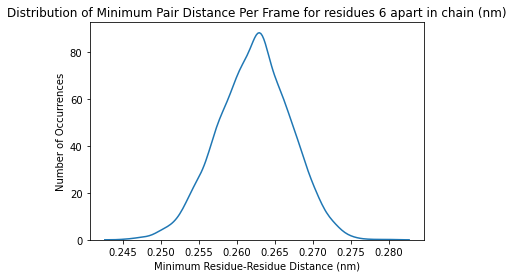

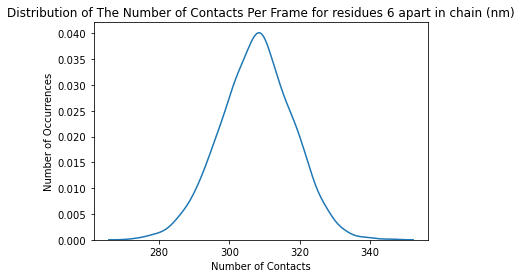

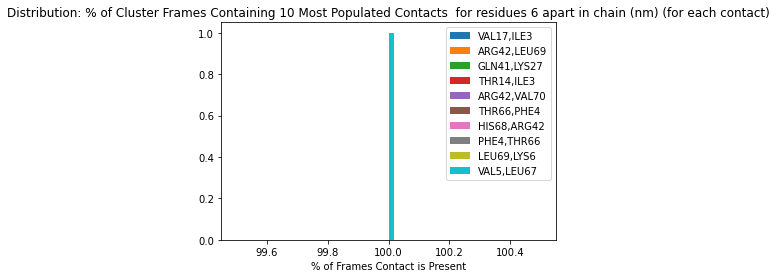

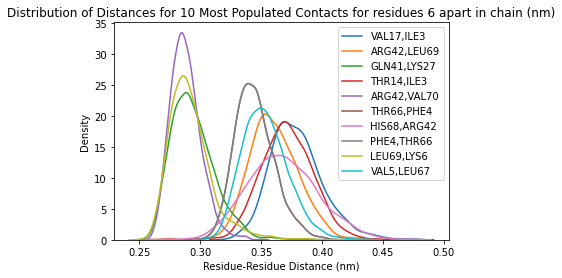

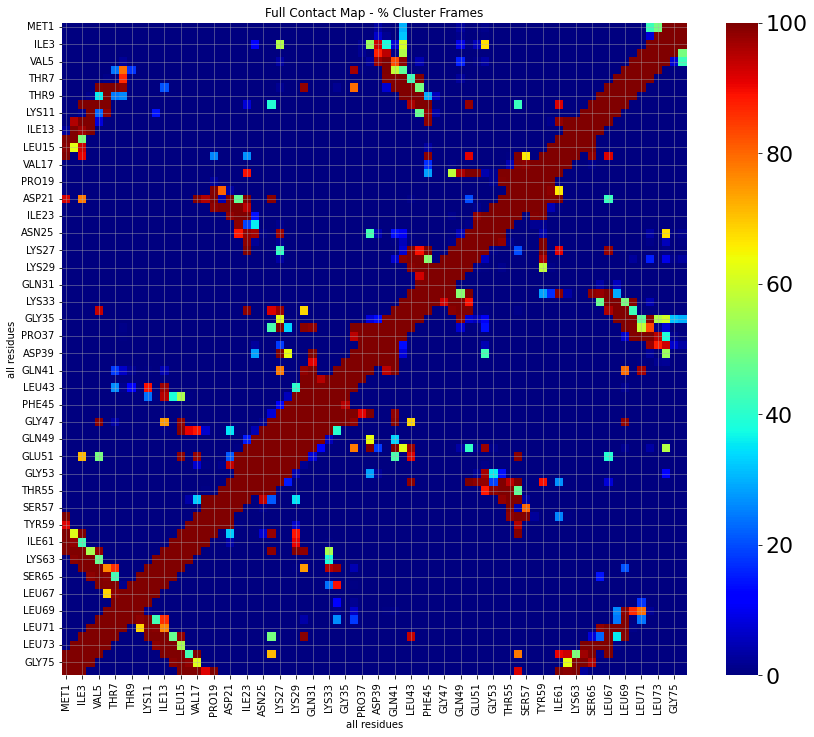

In [127]:
#for the third cluster
single_cluster(trj.n_residues,6,frames_cl_coor_pca[2],dist_feat_arr,0.5,pairs,pairs_res_index,index,columns,"Full Contact Map - % Cluster Frames",x,y)

In [ ]:
#now we can visualize all of the frames assigned to each cluster - im going to make a convienience function 
def vis(trj,frames):
    t1 = nv.MDTrajTrajectory(trj[frames])
    view1 = nv.NGLWidget(t1)
    return view1
    

In [38]:
#cluster zero - major state - has the highest fraction of secondary structure, for every element
t1 = nv.MDTrajTrajectory(trj[frames_cl_coor_pca[0]])
view1 = nv.NGLWidget(t1)
view1

NGLWidget(count=2089)

In [39]:
#cluster one - second most populated - most compact
t2 = nv.MDTrajTrajectory(trj[frames_cl_coor_pca[1]])
view2 = nv.NGLWidget(t2)
view2

NGLWidget(count=4961)

In [40]:
#cluster 2 - minor state - most disordered and least populated
t3 = nv.MDTrajTrajectory(trj[frames_cl_coor_pca[2]])
view3 = nv.NGLWidget(t3)
view3

NGLWidget(count=3038)

STOP PROBLEM 1

START PROBLEM 2

In [42]:
#im going to go straight to the part where I define a function to do this for all data stored in dict
def find_longest_autocoor(dic,key,lag,lags):
    coefs = []
    for i in [*dic[key].values()]:
        a = np.corrcoef(i[lag:],i[:-lag])[0][1]
        coefs.append(a)
    coefs = np.array(coefs)
    sorted_coefs = np.flip(np.sort(coefs))
    idx = np.array([*dic[key].keys()])
    idx_sorted = idx[np.flip(np.argsort(coefs))].astype(int)
    arr = np.stack([sorted_coefs,idx_sorted],axis=1)
    df = pd.DataFrame(data=arr,columns=["coef","resid"])
    time = np.linspace(0,1000,trj.n_frames)
    lags = range(50)
    plt.figure()
    for j in idx_sorted[:5].tolist():
        ac=autocorr1(dic[key][j],lags)
        plt.plot(time[lags],ac,label="res:{}".format(top.residue(j-1)))
    plt.title("Longest Autocorrelation Times for "+key+" values")
    plt.xlabel("Time ($\mu$s)", size=14, labelpad=15)
    plt.ylabel("Autocorrelation", size=14, labelpad=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xticks(size='14')
    plt.yticks(size='14')
    plt.legend()
    return df

coef  resid
0   0.779910   60.0
1   0.689963   35.0
2   0.498259   10.0
3   0.341930   40.0
4   0.294683   31.0
..       ...    ...
70 -0.011364   47.0
71 -0.011486   69.0
72 -0.012933   17.0
73 -0.013716   65.0
74 -0.017889    3.0

[75 rows x 2 columns]

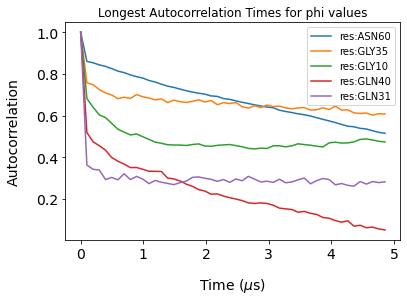

In [43]:
#for all phis

find_longest_autocoor(dihedral_dict,"phi",10,50)

In [44]:
#lets visualize the trajectory and light up the residues with highest phi autocorr
t4 = nv.MDTrajTrajectory(trj)
view4 = nv.NGLWidget(t4)
view4

NGLWidget(count=10088)

In [45]:
view4.clear_representations()
view4.add_cartoon(color="blue",opacity=.1)
view4.add_licorice("59, 34, 9, 39, 30")


coef  resid
0   0.834293   30.0
1   0.807534   31.0
2   0.692343   34.0
3   0.664237   13.0
4   0.586227   32.0
..       ...    ...
70 -0.013297   74.0
71 -0.013479   48.0
72 -0.014433    3.0
73 -0.016603   61.0
74 -0.024865   16.0

[75 rows x 2 columns]

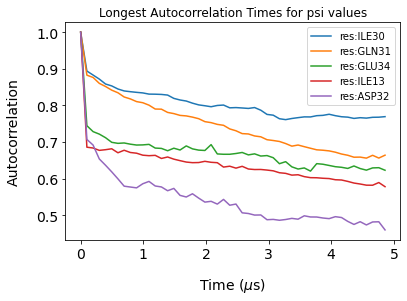

In [46]:
#for all psi values
find_longest_autocoor(dihedral_dict,"psi",10,50)

In [47]:
#lets visualize the trajectory and light up the residues with highest psi autocorr
t5 = nv.MDTrajTrajectory(trj)
view5 = nv.NGLWidget(t5)
view5

NGLWidget(count=10088)

In [48]:
view5.clear_representations()
view5.add_cartoon(color="blue",opacity=.1)
view5.add_licorice("29, 30, 33, 12, 31")

coef  resid
0   0.200708   36.0
1   0.190338    9.0
2   0.130158   30.0
3   0.114617    7.0
4   0.112648   23.0
..       ...    ...
63 -0.012197   61.0
64 -0.012275   57.0
65 -0.013951    8.0
66 -0.015676   54.0
67 -0.017188   31.0

[68 rows x 2 columns]

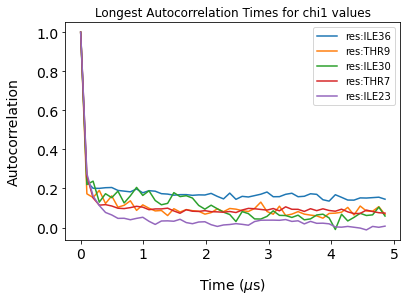

In [49]:
#for all chi1
find_longest_autocoor(dihedral_dict,"chi1",3,10)

In [50]:
#lets visualize the trajectory and light up the residues with highest chi1 autocorr
t6 = nv.MDTrajTrajectory(trj)
view6 = nv.NGLWidget(t6)
view6

NGLWidget(count=10088)

In [51]:
view6.clear_representations()
view6.add_cartoon(color="blue",opacity=.1)
view6.add_licorice("35, 8, 29, 6, 22")

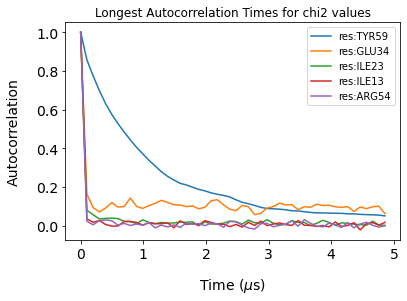

In [52]:
#for all chi2
chi2_auto=find_longest_autocoor(dihedral_dict,"chi2",3,10)

In [53]:
#lets visualize the trajectory and light up the residues with highest chi2 autocorr
t7 = nv.MDTrajTrajectory(trj)
view7 = nv.NGLWidget(t7)
view7

NGLWidget(count=10088)

In [54]:
view7.clear_representations()
view7.add_cartoon(color="blue",opacity=.1)
view7.add_licorice("58, 33, 22, 12, 53")

END PROBLEM 2

In [55]:
#TRYING DIFFERENT FEATURES AND DIM REDUCTION TECHNIQUES FROM HERE ON OUT

In [156]:
#make dihedral feature array
dihed_arr = np.concatenate([phis,psis],axis=1)

In [159]:
##lets try a different feature for dim red
pca2 = PCA(n_components=2)
trj.superpose(trj, 0)
reduced_dihed = pca1.fit_transform(dihed_arr)

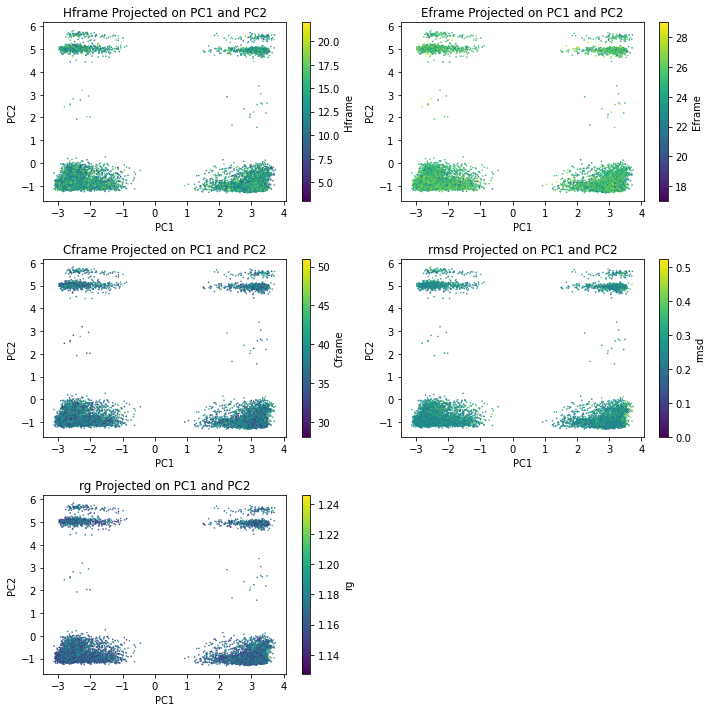

In [160]:
proj(reduced_dihed,data,per_frame,"PC")

In [161]:
#lets try a more nuanced feature - min distance between residues and see if we get better separation
feat = pyemma.coordinates.featurizer(pdb) 
feat.add_residue_mindist()

03-02-22 00:38:36 pyemma.coordinates.data.featurization.featurizer.MDFeaturizer[2] WARNING  Using all residue pairs with schemes like closest or closest-heavy is very time consuming. Consider reducing the residue pairs


In [162]:
reader = pyemma.coordinates.load(trajectory, features=feat) 

In [163]:
pca = pyemma.coordinates.pca(reader, var_cutoff = .95)
p = pca.get_output()[0]

Text(0.5, 1.0, 'PC1/2 free energy for minimum residues distances')

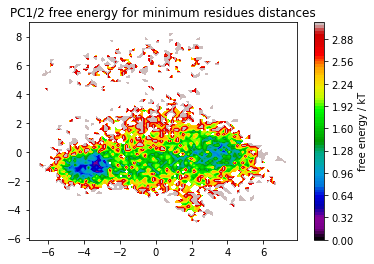

In [164]:
_=pyemma.plots.plot_free_energy(*p[:,:2].T, legacy = False)
plt.title("PC1/2 free energy for minimum residues distances")

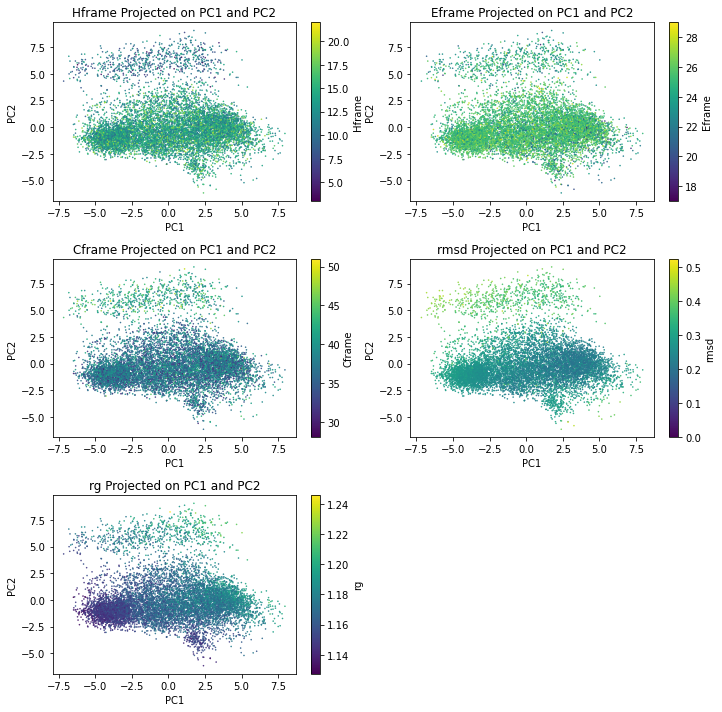

In [165]:
#this dim reduction seems to have separated helix states(1) and coil states(2), we can also see the that
#that the compacted state has been retained from the rg projection(4)
##overall one could argue that we have separated out 3 distinct states
proj(p,data,per_frame,"PC")
    

In [166]:
#let's try the min_dist feature matrix with tica and see what we get
tica_min_dist = pyemma.coordinates.tica(reader, var_cutoff = .95)
t_min_dist = tica_min_dist.get_output()[0]

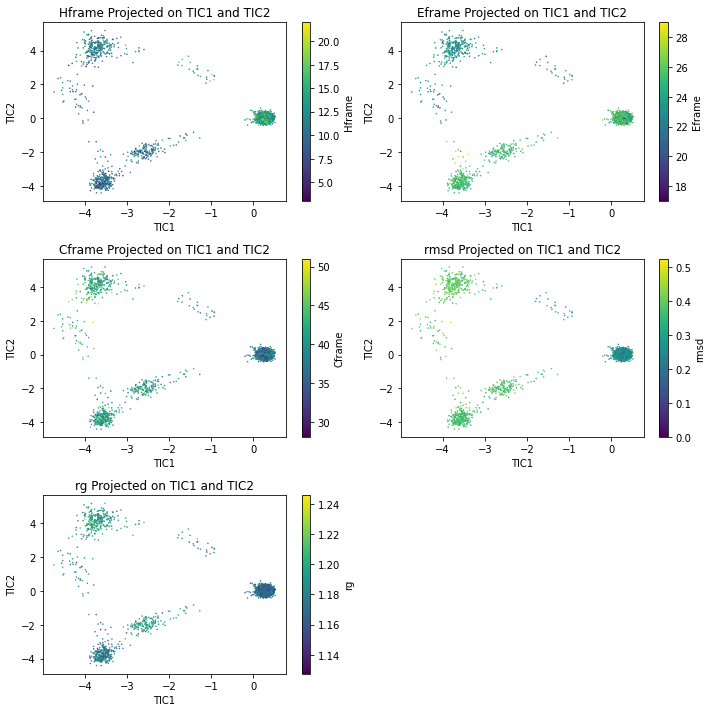

In [167]:
#as one could see (less clearly) before, there are approximatley 3-4 states, with one being more compact and helical
##than the others
proj(t_min_dist,data,per_frame,"TIC")